In [67]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [68]:
def draw_sudoku(matrix, edge_color1='black', edge_color2='black',title = ''):
    # Tworzenie siatki do wyświetlenia planszy sudoku
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(0, 10, 1))
    ax.set_yticks(np.arange(0, 10, 1))

    # Dodanie linii przerywanych oddzielających pola 3x3
    for i in range(1,9):
        if i % 3 == 0 : continue
        ax.plot([i, i], [0, 9], color=edge_color2, linestyle='--', linewidth=1)
        ax.plot([0, 9], [i, i], color=edge_color2, linestyle='--', linewidth=1)
        
    # Podział na czerwone linie co 3 kolumny i co 3 wiersze
    for i in range(0, 10, 3):
        ax.plot([i, i], [0, 9], color=edge_color1, linestyle='-', linewidth=2)
        ax.plot([0, 9], [i, i], color=edge_color1, linestyle='-', linewidth=2)

    # Wyświetlenie wartości na planszy
    for i in range(9):
        for j in range(9):
            val = str(int(matrix[i, j]))
            if val == '0' : continue
            ax.text(j + 0.5, 8.5 - i, val, va='center', ha='center')
    

    # Ukrycie ticków
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title(title)
    plt.show()


In [69]:
def sudoku_matrix(filename = None) :
    table = np.zeros((9,9))
    if filename == None : return table
    with open(filename, "r") as file :
        lines = file.readlines()
        for i in range(len(lines)) :
            line = lines[i].strip()
            for j in range(9) :
                if line[j] == 'x' or line[j] == ' ' : continue
                table[i][j] = int(line[j])
    
    return table

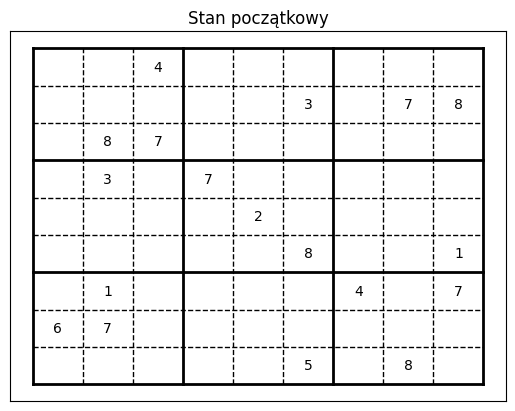

In [70]:
# Przykładowe użycie:
numbers = sudoku_matrix('sudoku2.txt')
draw_sudoku(numbers,title = 'Stan początkowy')

In [71]:
def fill_matrix(matrix) :
    good_points = np.zeros((9,9))
    appearances = np.full(9, 9)

    for x in range(9) :
        for y in range(9) :
            val = int(matrix[x,y])
            if val > 0 :
                good_points[x,y] = 1
                appearances[val - 1] -= 1
    idx = 0
    
    for x in range(9) :
        for y in range(9) :
            if matrix[x,y] == 0 :
                idx = np.random.choice(9)
                while appearances[idx] == 0 : idx = np.random.choice(9)
                matrix[x,y] = idx + 1
                appearances[idx] -= 1
    return matrix, good_points

In [72]:
def energy(matrix, point, tellrange = False) :
    x,y = point
    if tellrange : table = []
    val = matrix[x,y]
    E = 0
    for i in range(9) :
        if i == x : continue
        if matrix[i,y] == val :
            E += 1
            if tellrange : table.append((i,y))
    
    for i in range(9) :
        if i == y : continue
        if matrix[x,i] == val :
            E += 1
            if tellrange : table.append((x,i))
    
    i_start = x // 3
    j_start = y // 3
    # print(i_start, j_start)
    
    for i in range(3) :
        for j in range(3) :
            i_val = i_start*3 + i
            j_val = j_start*3 + j
            if i_val == x or j_val == y : continue
            if matrix[i_val,j_val] == val :
                E += 1
                if tellrange : table.append((i_val,j_val))
    if tellrange : return set(table), E
    return E

In [73]:
def whole_energy(matrix, matrix_gen = False) :
    n = 9
    if matrix_gen :
        tab = np.zeros((n, n))
    E = 0
    for i in range(n) :
        for j in range(n) :
            val = energy(matrix,(i,j))
            E += val
            if matrix_gen : tab[i][j] = val
    if matrix_gen : return tab, E
    return E

In [74]:
def symulated_annealing_sudoku(matrix, good_points, iterations = 1_000,T = 5_000, cooling_rate = 0.995) :
    E = whole_energy(matrix)
    E_tab = [E]
    temp_tab = [T]
    n = 9
    
    counter = 0
    start = time.time()
    
    for _ in range(iterations) :
        if _ % (iterations // 10) == 0 : print(_ // (iterations // 100),'%, E =',E, ' Time:',round(time.time()-start,2))
        if E <= 0 :
            counter += 1
        if counter >= _/10 and counter > 0 :
            print(_ // (iterations // 100),'%, E =',E, ' Time:',round(time.time()-start,2))
            return E_tab,temp_tab,matrix
        
        
        a_ind_candidates = np.argwhere(good_points == 0)
        a_ind = tuple(a_ind_candidates[np.random.choice(len(a_ind_candidates))])
        
        b_ind_candidates = np.argwhere(np.logical_and(matrix != matrix[a_ind], good_points == 0))
        b_ind = tuple(b_ind_candidates[np.random.choice(len(b_ind_candidates))])
        
        
        d_E = 0
        
        
        a_range,a_E = energy(matrix,a_ind,True)
        b_range,b_E = energy(matrix,b_ind,True)
        
        d_E -= a_E + b_E + len(a_range) + len(b_range)
        
        matrix[a_ind], matrix[b_ind] = matrix[b_ind], matrix[a_ind]
        
        a_range,a_E = energy(matrix,a_ind,True)
        b_range,b_E = energy(matrix,b_ind,True)
        
        d_E += a_E + b_E + len(a_range) + len(b_range)
        
        
        if (d_E < 0) or (np.exp(-d_E/T) > np.random.uniform(0,1)) :
            E += d_E
        else :
            matrix[a_ind], matrix[b_ind] = matrix[b_ind], matrix[a_ind]
        
        T *= cooling_rate
        E_tab.append(E)
        temp_tab.append(T)
    print(100,'%, E =',E, ' Time:',round(time.time()-start,2))
    return E_tab,temp_tab,matrix

In [75]:
numbers, correct = fill_matrix(numbers)

# draw_sudoku(numbers)


# plot_points,sudoku = symulated_annealing_sudoku(numbers, correct,100_000_000,50_000_000, 0.9999998)
# plot_points_e,plot_points_t,sudoku = symulated_annealing_sudoku(numbers, correct,500_000,500_000, 0.9999)
plot_points_e,plot_points_t,sudoku = symulated_annealing_sudoku(numbers, correct, 10_000_000, 1_000_000, 0.9999982)


0 %, E = 138  Time: 0.0


KeyboardInterrupt: 

In [ ]:
def plot_graph(plot_points,title = '', y_label = '', x_label = '') :
    plt.plot([_ for _ in range(len(plot_points))], plot_points)

    col = 'red'
    if plot_points[-1] < plot_points[0] :
        col = 'green'

    plt.axhline(y=plot_points[0], color=col, linestyle='--')

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    print(f"0: {plot_points[0]}, {len(plot_points) - 1}: {plot_points[-1]}")

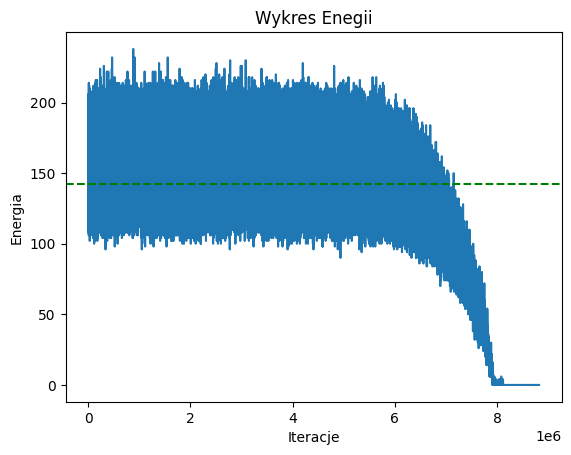

0: 142, 8824220: 0


In [ ]:
plot_graph(plot_points_e,'Wykres Enegii','Energia','Iteracje')

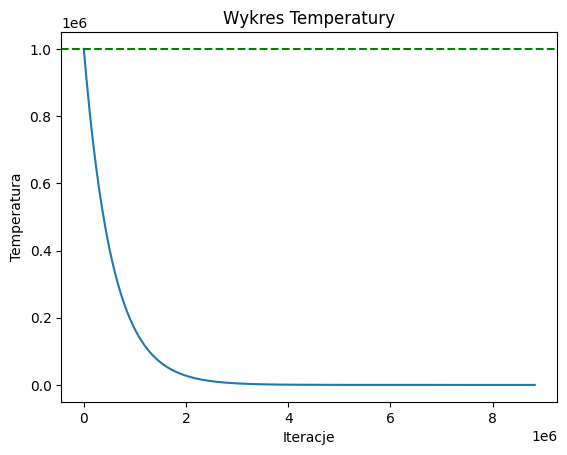

0: 1000000, 8824220: 0.1264257957555982


In [ ]:
plot_graph(plot_points_t,'Wykres Temperatury','Temperatura','Iteracje')

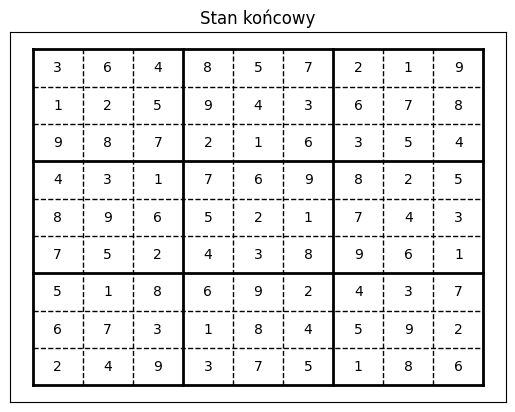

0


In [ ]:
# Printowanie sudoku
draw_sudoku(numbers,title = 'Stan końcowy')
print(whole_energy(numbers))